## Advanced Lane Finding Project


Steps for the pipeline are;

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Detect lane lines
1. Determine the lane curvature


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline



## Calibrate The Camera

In [2]:
class CalibrateCamera:
    # Note these are class variables, so you only every have to read images once
    ret, mtx, dist, rvecs, tvecs = None,None,None,None,None
    objpoints = []
    imgpoints = []
    cal_images = []
    
    def __init__(self):
        self.readCalibrationImages()

    def readCalibrationImages(self):
        if len (self.cal_images) > 0:
            return
        # prepare object points
        nx = 9 #TODO: enter the number of inside corners in x
        ny = 6 #TODO: enter the number of inside corners in y

        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coord

        images = glob.glob("./camera_cal/*.jpg")

        # Make a list of calibration images

        for fname in images:
            print (fname)
            img = mpimg.imread(fname)

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If found, draw corners
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                #print (corners[0], corners[nx-1],corners[-1],corners[-nx])

            self.cal_images.append((img,fname))

    def getCalibrationImages(self):
        return self.cal_images
    
    def getCameraCalibration(self,image_shape):
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, image_shape, None, None)

    def undistortImage(self,image):
        return cv2.undistort(image,self.mtx,self.dist,None,self.mtx)

./camera_cal/calibration5.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg


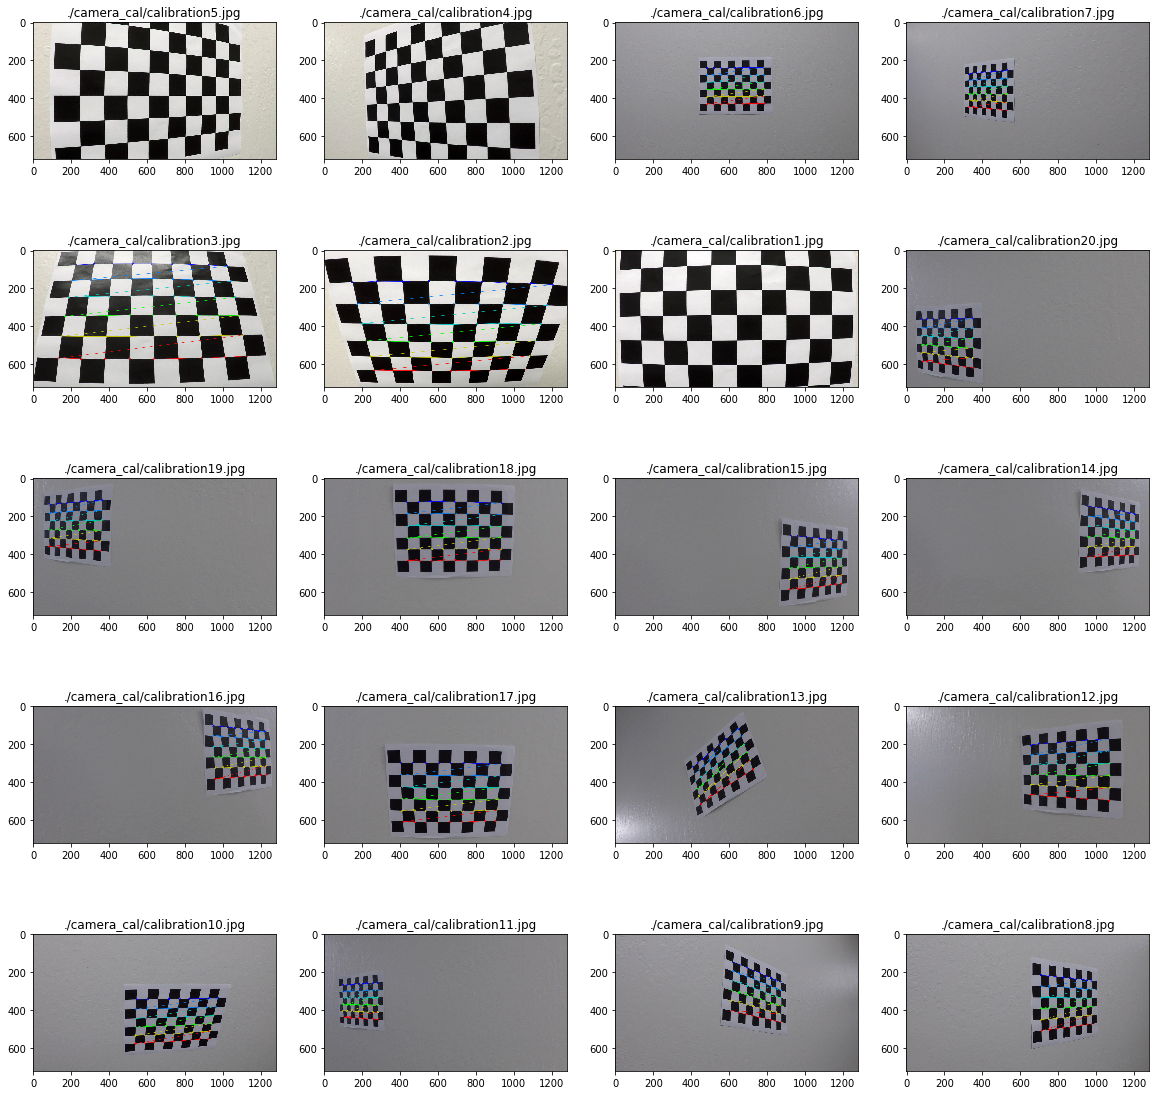

In [3]:
camCal = CalibrateCamera()

cal_images = camCal.getCalibrationImages()


f, ax = plt.subplots(5, 4, figsize=(20, 20))

ax = ax.ravel()

for cal_image,axi in zip(cal_images,ax):
    axi.imshow(cal_image[0])
    axi.set_title(cal_image[1])

plt.subplots_adjust(hspace=0.3)
plt.show()



## Threshold Functions

## Show Chessboard Undistorted

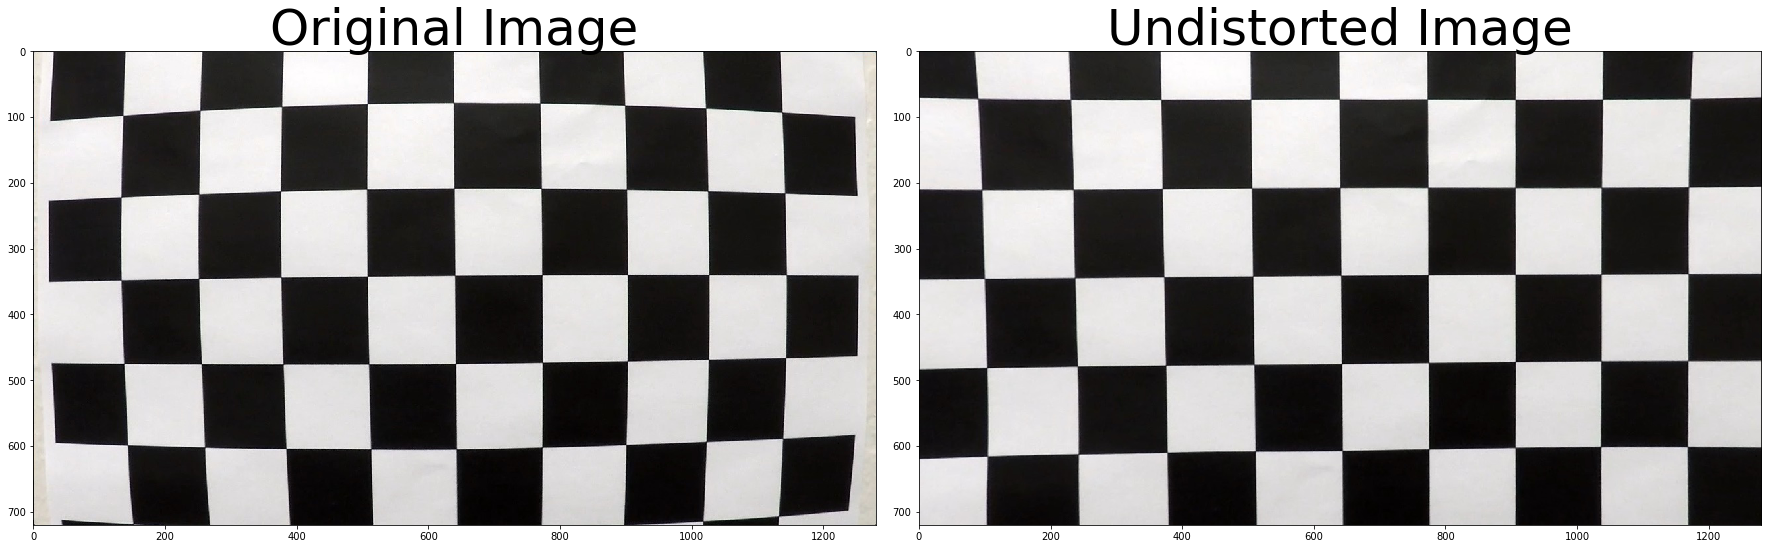

In [4]:
cal_image = mpimg.imread("./camera_cal/calibration1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort Test Image

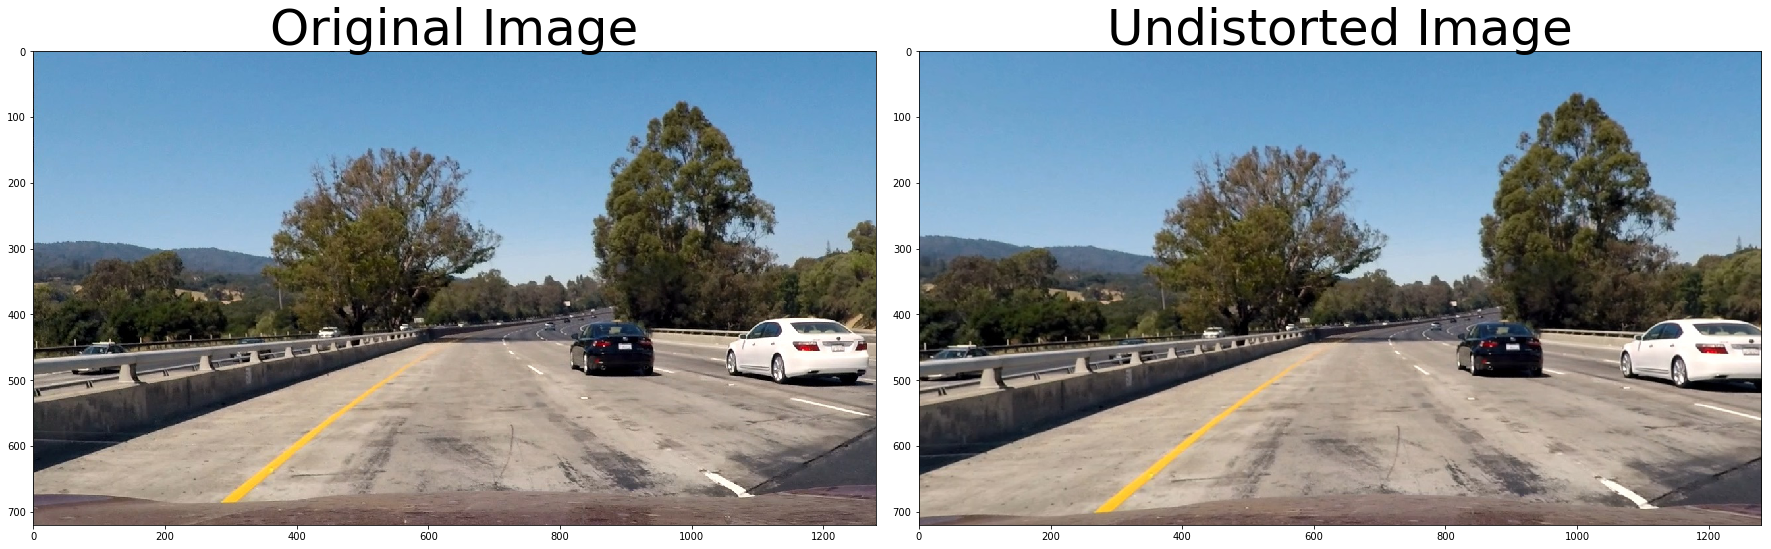

In [5]:
cal_image = mpimg.imread("./test_images/test1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient & Threshold functions


In [6]:

# Class that takes an image and lets you pick appropriate Channels from different
# Color spaces
class ImageChannel():
    image = None
    def __init__(self,img):
        # Initial RGB image
        self.image = img

    def getChannel(self, channel):
        """Dispatch method"""
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, channel, lambda: "nothing")
        # Call the method as we return it
        return method()

    def GRAY(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)

    def RGB_R(self):
        return image[:,:,0]

    def RGB_G(self):
        return image[:,:,1]

    def RGB_B(self):
        return image[:,:,2]

    def HLS_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HLS_L(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HLS_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    def HSV_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HSV_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HSV_V(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]

    
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', channel="GRAY", sobel_kernel=3, thresh=(0,255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, channel="GRAY", sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, channel="GRAY", sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_thresh (img, channel="GRAY", thresh=(170,255)):
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)

    binary = np.zeros_like(img_channel)
    binary[(img_channel >= thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary



## Gradient & Threshold Visualizations

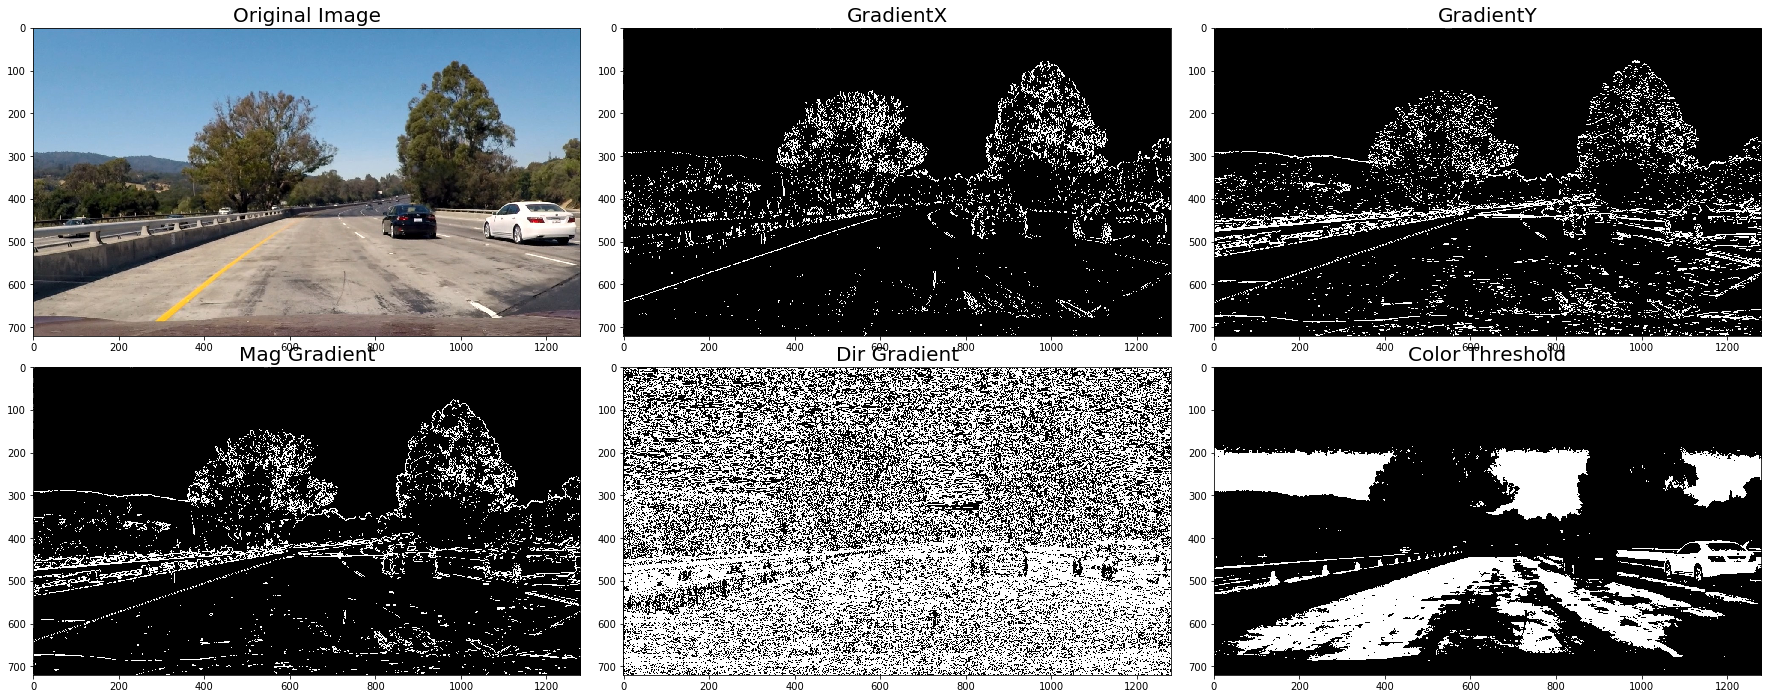

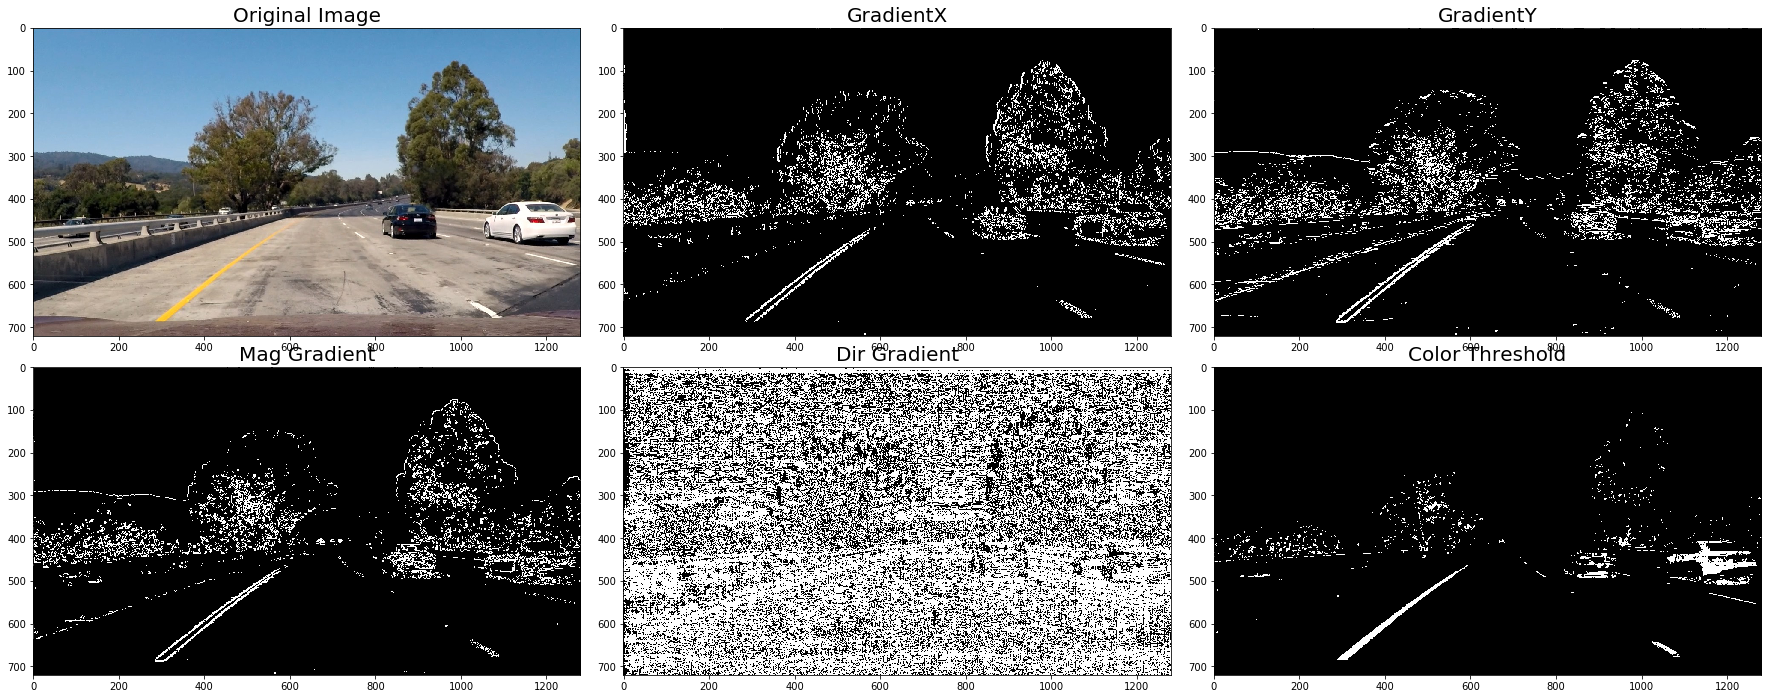

In [7]:
# Read in an image and grayscale it
ksize = 3
image = mpimg.imread('./test_images/test1.jpg')

gradx = abs_sobel_thresh(image, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="GRAY", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="GRAY", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="GRAY", thresh=(170,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

gradx = abs_sobel_thresh(image, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="HLS_S", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="HLS_S", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="HLS_S", thresh=(150,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

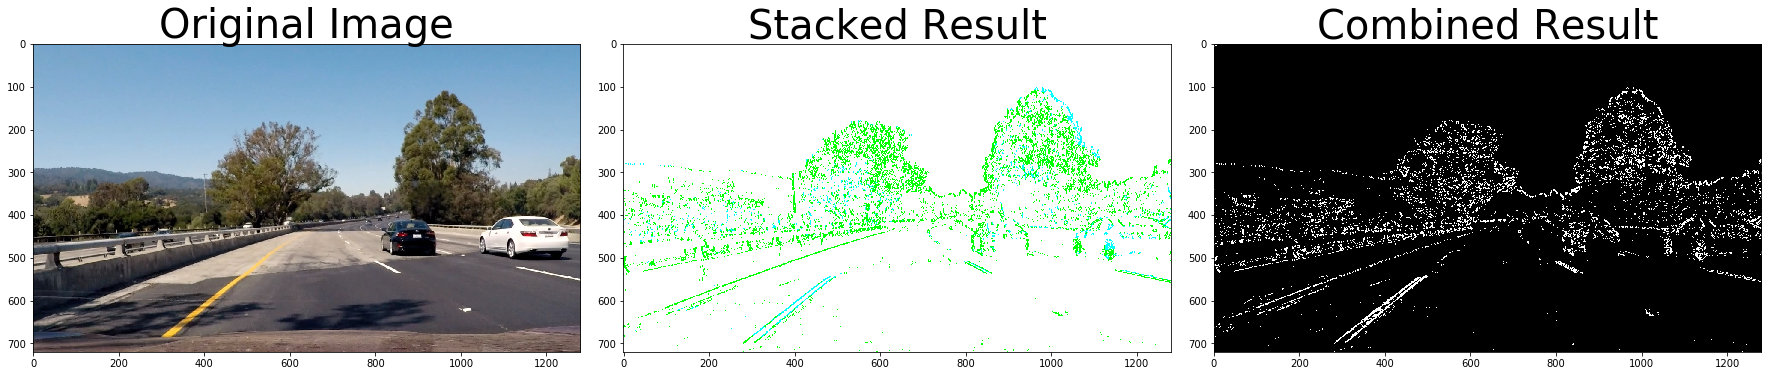

In [124]:
image = mpimg.imread('./test_images/test4.jpg')

# Edit this function to create your own pipeline.
def pipeline(img):
    img = np.copy(img)
    undistorted = camCal.undistortImage(img)


    gradx_g = abs_sobel_thresh(undistorted, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 150))
    grady_g = abs_sobel_thresh(undistorted, orient='y', channel="GRAY", sobel_kernel=15, thresh=(20, 150))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(15, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    #gradx_l = abs_sobel_thresh(undistorted, orient='x', channel="HLS_L", sobel_kernel=ksize, thresh=(20, 100))
    #gradx_s = abs_sobel_thresh(undistorted, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
    color_s = color_thresh(image, channel="HLS_S", thresh=(100, 255))
    color_l = color_thresh(image, channel="HLS_L", thresh=(220, 255))
    color_v = color_thresh(image, channel="HSV_V", thresh=(210, 255))

    #color_t = color_thresh(undistorted, channel="HLS_S", thresh=(150,255))


    color_binary = np.dstack(( np.zeros_like(gradx_g), gradx_g, color_s, gradx_g)) * 255
    
    combined_binary = np.zeros_like(gradx)
    #combined_binary[(gradx_l ==1) | (color_t ==1) | (gradx_s==1) ] = 1
    #combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_l == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1


    return color_binary, combined_binary
    
stacked, combined = pipeline(image)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(stacked, cmap="gray")
ax2.set_title('Stacked Result', fontsize=40)

ax3.imshow(combined, cmap="gray")
ax3.set_title('Combined Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## Perspective Transform

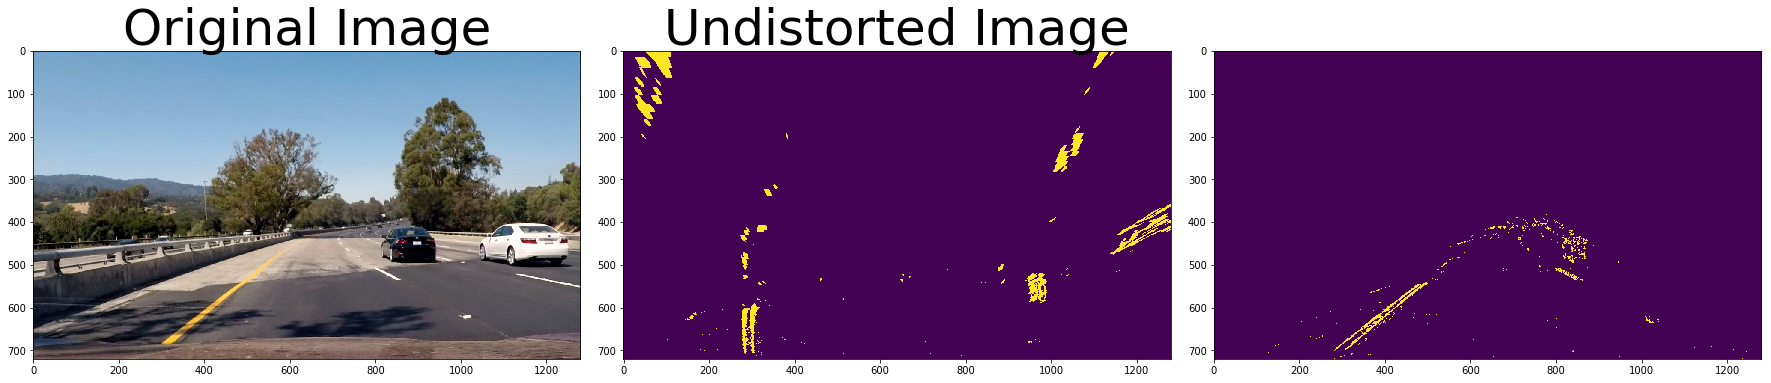

In [125]:
def get_transform_matrix():
    img = mpimg.imread('test_images/straight_lines1.jpg')
    h,w= img.shape[:2]

    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])

#    src = np.float32(
#        [[685, 450], 
#          [1100, 710], 
#          [200, 710], 
#          [595, 450]])
#    
#    dst = np.float32(
#        [[900, 0], 
#          [900, 710], 
#          [250, 710], 
#          [250, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

# Remove a region of an image
def remove_region(img, triangle):
    mask = np.ones_like(img) 
    mask = cv2.fillPoly(mask, [triangle], 0)

    new_combined = np.zeros_like(img)
    new_combined[((img == 1) & (mask == 1))] = 1
    
    return new_combined

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cal_image = mpimg.imread("./test_images/test4.jpg")

stacked,processed = pipeline(cal_image)

# Remove a piece of the road between te lanes. This removes some noise that may be in between the lane lines
#h,w= processed.shape[:2]
#triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
#processed = remove_region(processed, triangle)
pHeightMask=1.7
imshape = cal_image.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]/pHeightMask, imshape[0]/2), (imshape[1]/pHeightMask, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
processed = region_of_interest(processed,vertices)
    
M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(processed)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

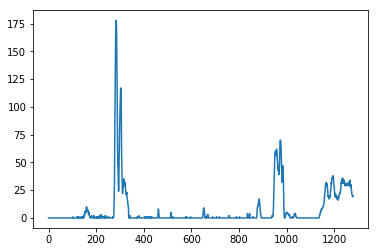

In [126]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Orig Sliding Window


(720, 0)

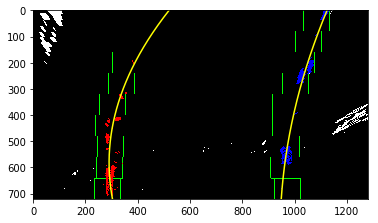

In [127]:
binary_warped = np.copy(warped)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#print ("Left Shape->",left_fit.shape, leftx.shape, lefty.shape)
#print ("Left-> ",left_fit, leftx, lefty)
#print ("Right-> ",right_fit, right_fitx)

## Sliding Window Search (CLASS)

In [113]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def updateLine(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.radius_of_curvature is None:
            diff = 0.0
        else:
            diff = abs(self.radius_of_curvature - radius)

        if (diff/radius > 0.8):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            print ("Old:",self.radius_of_curvature," New:",radius, "Diff:",diff)

            resetWindow = True
        else:
            self.radius_of_curvature = radius
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 10):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position

            
        return resetWindow
        
    def updateLine_old(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.current_fit is None:
            diff = np.array([0,0,0], dtype='float')
        else:
            diff = np.absolute(self.current_fit - fit)

        if (abs(diff[0]/fit[0]) > 0.3) | (abs(diff[1]/fit[1]) > 0.3) | (abs(diff[2]/fit[2]) > 0.3):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            resetWindow = True
        else:
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 5):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position
            
        return resetWindow

class SlidingWindow():
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    def __init__(self):
        self.leftLine = Line()
        self.rightLine = Line()
        self.first_pass = True
        self.resetWindowParams ()
        return

    def resetWindowParams(self):
        print ("First Pass")
        self.leftLine = Line()
        self.rightLine = Line()
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty = None,None,None,None,None
        self.left_fit_cr, self.right_fit_cr = None, None
        self.nonzeroy, self.nonzerox = None, None
        return

    def polyfit(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            
        left_curverad, right_curverad= self.calc_curve()
        position = self.calc_lane_position(binary_warped)
        resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
        resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)

        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            left_curverad, right_curverad= self.calc_curve()
            position = self.calc_lane_position(binary_warped)

            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)
        return out_img
    
    def polyfit_old(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        return out_img

    def sliding_window_polyfit(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        self.left_lane_inds = []
        self.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        return out_img

    def plot1(self,binary_warped, out_img, ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        ax.imshow(out_img)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()
        
    def no_sliding_polyfit(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        self.left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
        self.left_fit[2] - self.margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
        self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        self.right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
        self.right_fit[2] - self.margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
        self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        return out_img
        #plt.imshow(out_img)
        #plt.plot(self.left_fitx, self.ploty, color='yellow')
        #plt.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()

    def calc_lane_position(self, image):
        center_pos = image.shape[1]/2.0
        lane_pos = (self.left_fitx[::-1][0] + self.right_fitx[::-2][0]) / 2.0
        return abs (lane_pos - center_pos) * self.xm_per_pix
    
    def calc_curve(self):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        #print(left_curverad, right_curverad)


        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*self.left_fit_cr[0]*y_eval*self.ym_per_pix + self.left_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.left_fit_cr[0])
        right_curverad = ((1 + (2*self.right_fit_cr[0]*y_eval*self.ym_per_pix + self.right_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.right_fit_cr[0])
        # Now our radius of curvature is in meters
        return left_curverad, right_curverad


    def plot_poly(self, binary_warped,ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-self.margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+self.margin, 
                                      self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-self.margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+self.margin, 
                                      self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #ax.xlim(0, 1280)
        #ax.ylim(720, 0)
        
    def drawLane(self,warped,image, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        best_left_fit = self.leftLine.best_fit
        best_right_fit = self.rightLine.best_fit
        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([best_left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([best_right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        return result

    def drawData(self,image):
        font = cv2.FONT_HERSHEY_PLAIN
        text = "Radius of curve: %.2f m" % ((self.leftLine.radius_of_curvature + self.rightLine.radius_of_curvature)/2.0)
        cv2.putText(image,text,(500,500),font, 2, (255,255,255), 2, cv2.LINE_AA)
        text = "Lane: %.2f m" % (self.leftLine.line_base_pos)
        cv2.putText(image,text,(500,600),font, 2, (255,255,255), 2, cv2.LINE_AA)

        return image
        


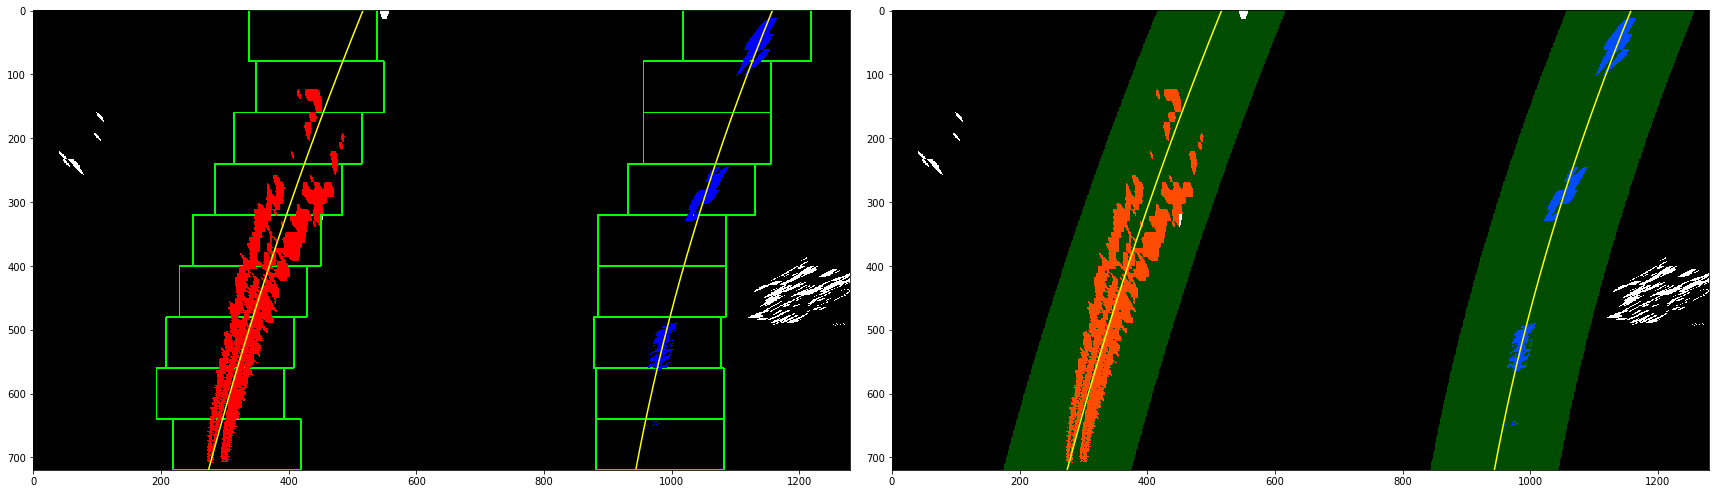

5818.458688731097 3423.5049698795874
1725.655880137171 m 1068.9433908004905 m


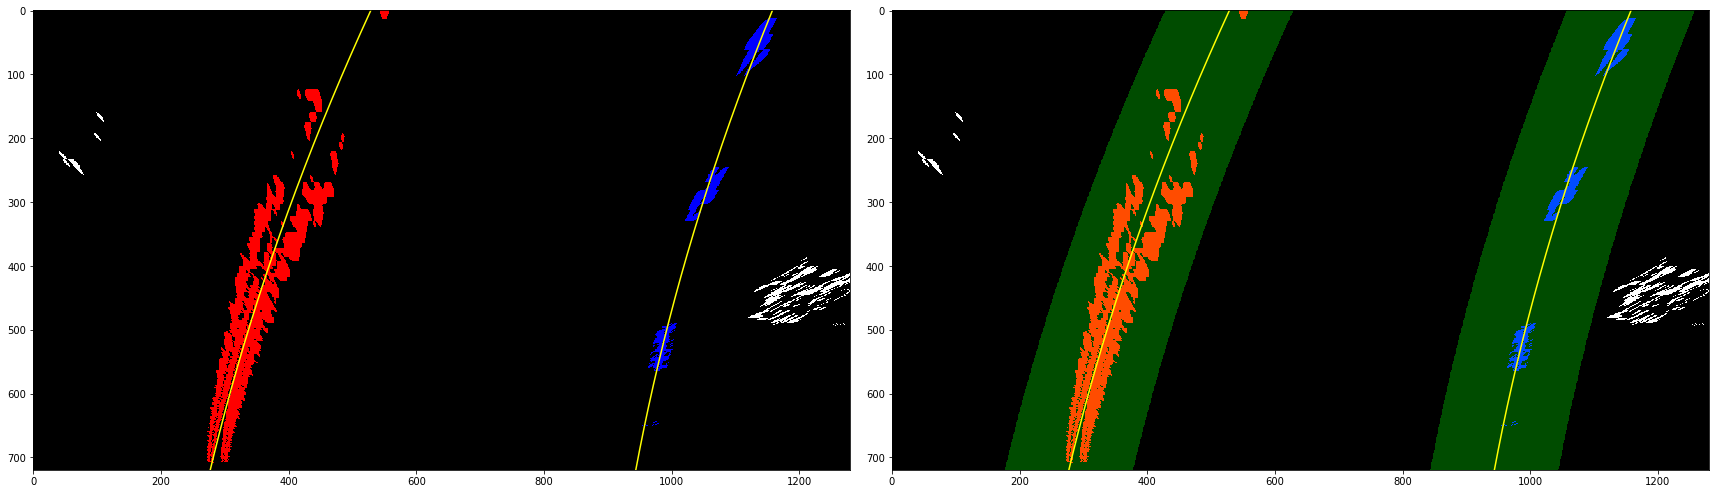

3547.495253229657 3423.5049698791563
1073.3165989044771 m 1068.943390800387 m


In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()        
binary_warped = np.copy(warped)
slideW = SlidingWindow()
out_img = slideW.sliding_window_polyfit(binary_warped)
slideW.plot1(binary_warped,out_img, ax1)


result = slideW.plot_poly(binary_warped,ax2)


plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

image = mpimg.imread('./test_images/test6.jpg')
stacked, combined = pipeline(image)

M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()       
binary_warped = np.copy(warped)

out_img = slideW.no_sliding_polyfit(binary_warped)
slideW.plot1(binary_warped,out_img,ax1)


result = slideW.plot_poly(binary_warped,ax2)

plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')

First Pass
./test_images/test1.jpg
First Pass


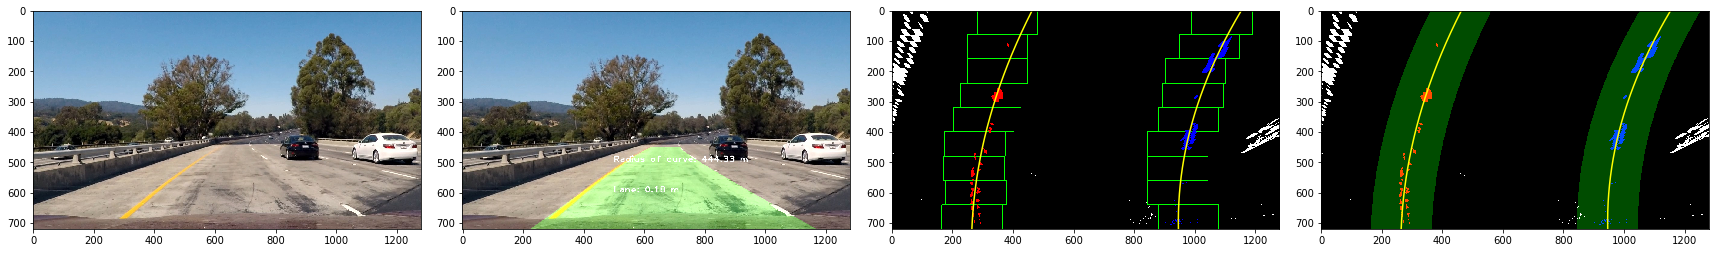

506.5377999561467 m 382.1241170034206 m
./test_images/test2.jpg
Old: 382.1241170034206  New: 173.84338918401716 Diff: 208.28072781940347
First Pass


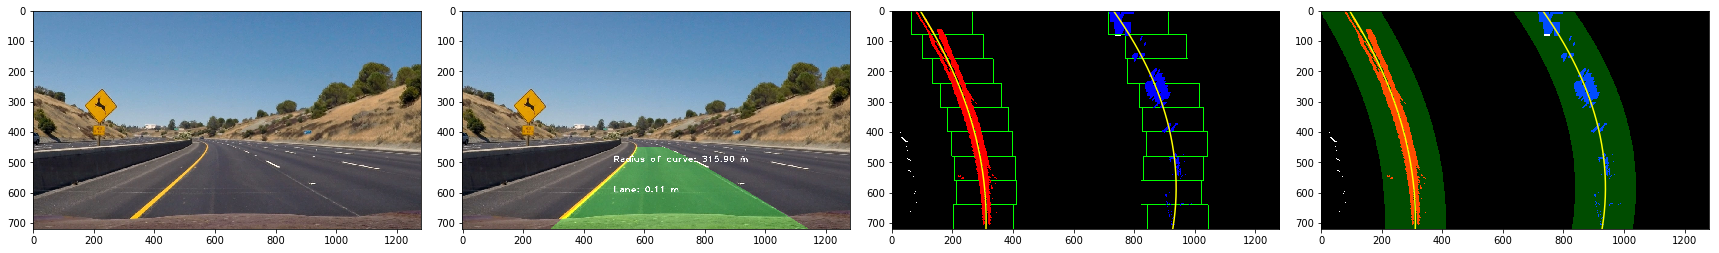

360.37077584987844 m 271.43553735291715 m
./test_images/test3.jpg
Old: 360.37077584987844  New: 126.22536147819307 Diff: 234.14541437168538
First Pass


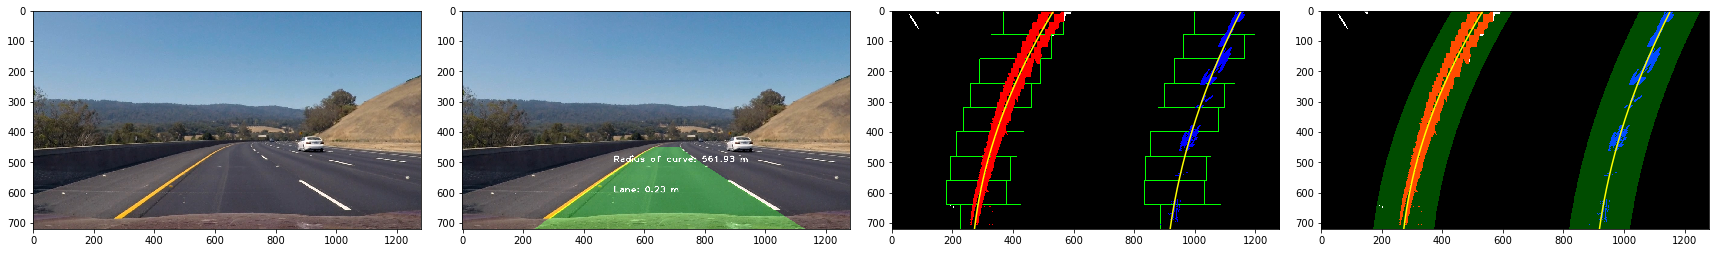

484.2807005213424 m 639.5738319588494 m
./test_images/test4.jpg
Old: 484.2807005213424  New: 250.28691604733064 Diff: 233.99378447401176
First Pass


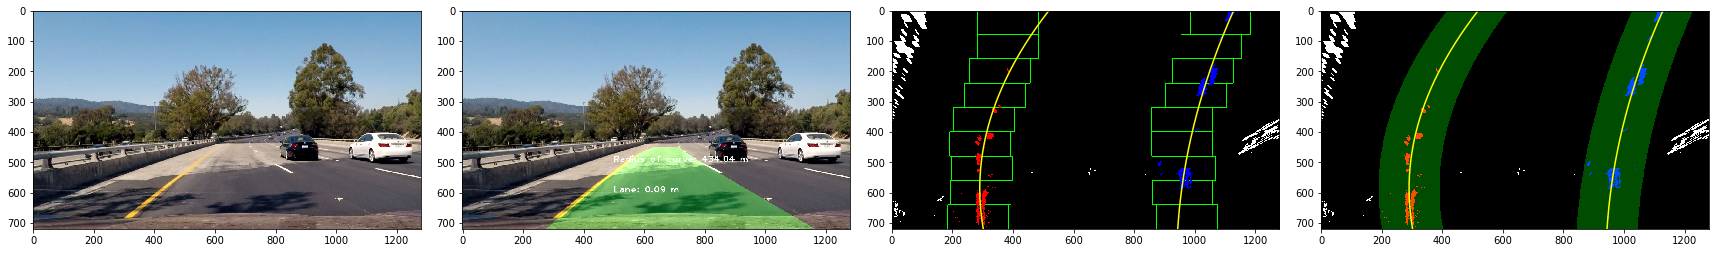

248.85572798478606 m 619.2172746577113 m
./test_images/test5.jpg
Old: 619.2172746577113  New: 331.4001782594185 Diff: 287.8170963982928
First Pass


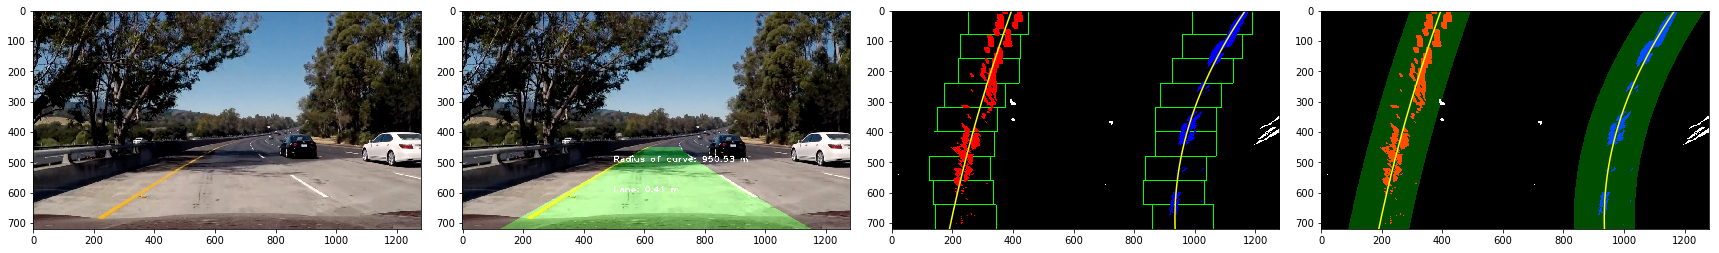

1568.3403528269382 m 332.7200654627532 m
./test_images/test6.jpg


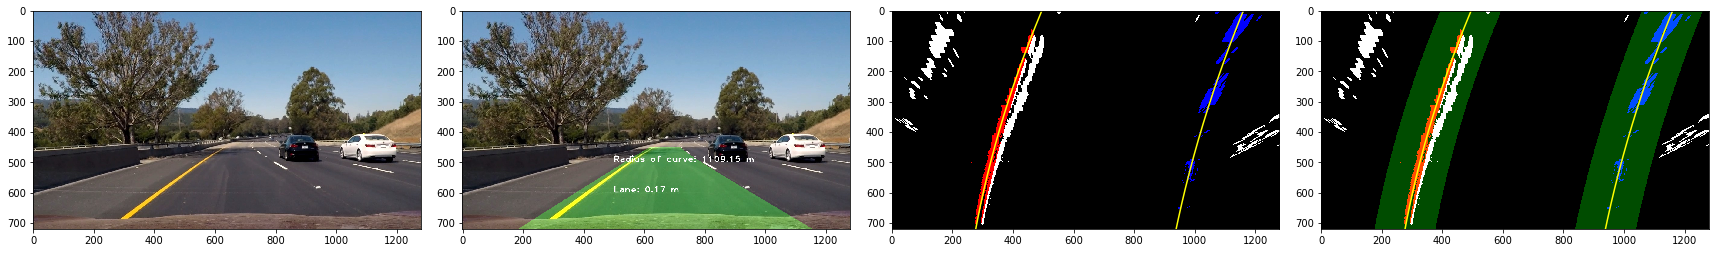

1021.3453866629367 m 1196.9565338321743 m
./test_images/test7.jpg
Old: 1196.9565338321743  New: 407.541283305612 Diff: 789.4152505265622
First Pass


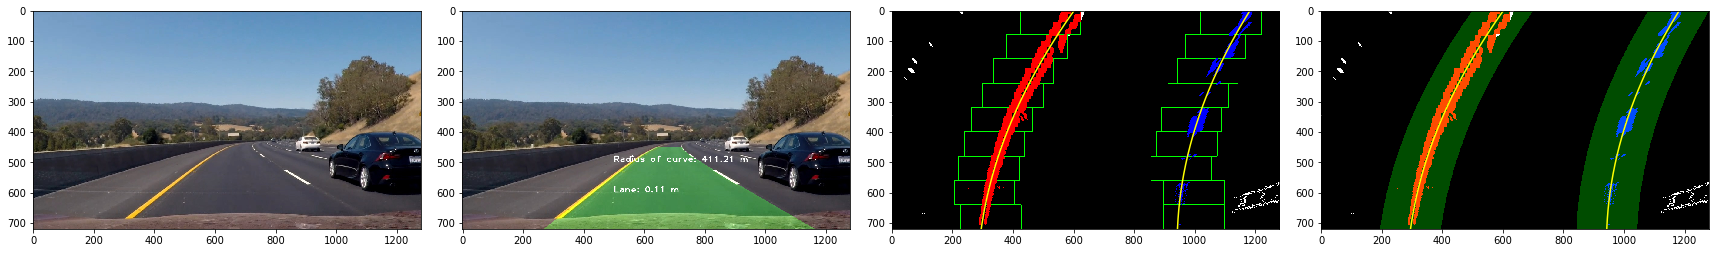

414.8724008180385 m 407.54128330582716 m
./test_images/test8.jpg


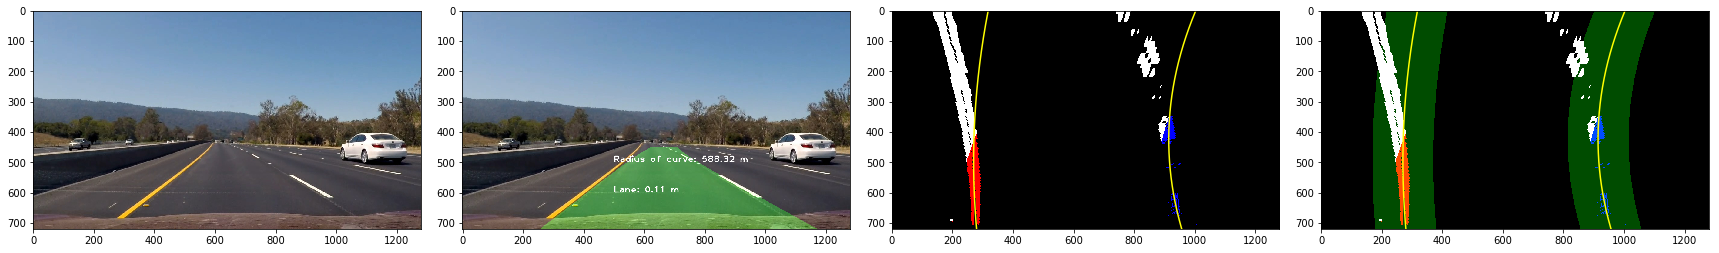

842.2117927419743 m 334.42688621061205 m
./test_images/test9.jpg


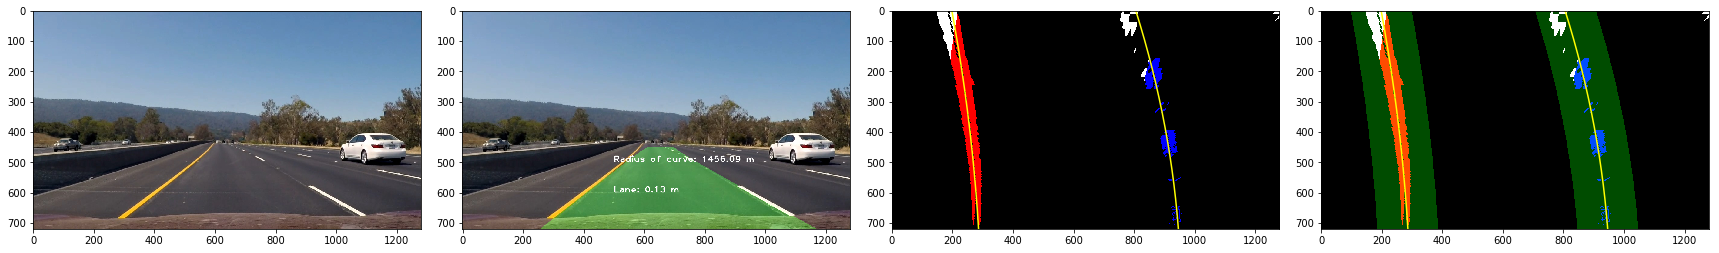

1920.3257777492327 m 991.8524797034316 m


In [128]:
images = glob.glob("./test_images/test*.jpg")

slide = SlidingWindow()
for n in range(1,10):

    fname = "./test_images/test%d.jpg" % n
    print (fname)
    image = mpimg.imread(fname)
    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    f, (ax,ax0,ax1, ax2) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout() 
    ax.imshow(image)
    binary_warped = np.copy(warped)

    out_img = slide.polyfit(binary_warped)
    slide.plot1(binary_warped,out_img,ax1)

    result = slide.plot_poly(binary_warped,ax2)
    lanes = slide.drawLane(binary_warped,image,Minv)
    lanes = slide.drawData(lanes)

    ax0.imshow(lanes)

    plt.show()

    left_curverad, right_curverad= slide.calc_curve()

    print(left_curverad, 'm', right_curverad, 'm')

In [129]:
videoSlide = SlidingWindow()


def process_image(image):

    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    binary_warped = np.copy(warped)

    out_img = videoSlide.polyfit(binary_warped)

    lanes = videoSlide.drawLane(binary_warped,image,Minv)

    lanes = videoSlide.drawData(lanes)
    return lanes

First Pass


In [130]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.set_start(0.0)
#clip1 = clip1.set_duration(4.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

First Pass
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



  2%|▏         | 31/1261 [00:09<06:13,  3.29it/s]

Old: 574.8440701590654  New: 251.91708230875628 Diff: 322.9269878503091
First Pass



  3%|▎         | 32/1261 [00:09<06:12,  3.30it/s]

Old: 1814.4613901069295  New: 891.4268339277353 Diff: 923.0345561791942
First Pass



  3%|▎         | 40/1261 [00:11<05:48,  3.51it/s]

Old: 2729.3627077560395  New: 1348.7693297170426 Diff: 1380.593378038997
First Pass



  4%|▍         | 53/1261 [00:15<05:52,  3.42it/s]

Old: 3030.9115967276057  New: 1045.7722198640859 Diff: 1985.1393768635198
First Pass



  4%|▍         | 54/1261 [00:15<05:59,  3.36it/s]

Old: 1153.7979608297107  New: 631.9420363574326 Diff: 521.8559244722782
First Pass



 11%|█         | 141/1261 [00:41<05:35,  3.34it/s]

Old: 655.5491877553292  New: 354.0339840487039 Diff: 301.51520370662524
First Pass



 13%|█▎        | 165/1261 [00:49<05:21,  3.40it/s]

Old: 1768.3883763557697  New: 914.2399635290047 Diff: 854.1484128267649
First Pass



 14%|█▍        | 174/1261 [00:51<05:13,  3.46it/s]

Old: 1829.0023213309444  New: 913.5074982337353 Diff: 915.4948230972091
First Pass



 14%|█▍        | 175/1261 [00:51<05:18,  3.41it/s]

Old: 9493.949466337277  New: 1636.553630157973 Diff: 7857.395836179304
First Pass



 14%|█▍        | 176/1261 [00:52<05:22,  3.36it/s]

Old: 40420.72921657827  New: 4798.763910043553 Diff: 35621.965306534716
First Pass



 14%|█▍        | 179/1261 [00:53<05:11,  3.47it/s]

Old: 24399.255034867012  New: 2630.072473590975 Diff: 21769.182561276037
First Pass



 15%|█▍        | 183/1261 [00:54<05:04,  3.54it/s]

Old: 5772.58315679994  New: 3086.919811245041 Diff: 2685.6633455548995
First Pass



 15%|█▍        | 184/1261 [00:54<05:09,  3.48it/s]

Old: 5664.2333045506075  New: 1353.1313341701873 Diff: 4311.10197038042
First Pass



 15%|█▍        | 185/1261 [00:54<05:13,  3.43it/s]

Old: 2958.550049657905  New: 1159.317224437917 Diff: 1799.2328252199882
First Pass



 15%|█▍        | 186/1261 [00:55<05:16,  3.40it/s]

Old: 2735.6566622484524  New: 740.7715263327425 Diff: 1994.88513591571
First Pass



 15%|█▍        | 187/1261 [00:55<05:28,  3.27it/s]

Old: 2458.689516942774  New: 850.6883387765458 Diff: 1608.001178166228
First Pass



 15%|█▍        | 188/1261 [00:55<05:30,  3.25it/s]

Old: 1174.7701321209072  New: 573.6201721791684 Diff: 601.1499599417388
First Pass



 15%|█▍        | 189/1261 [00:56<05:43,  3.12it/s]

Old: 1011.0432239198578  New: 560.0577194851586 Diff: 450.98550443469924
First Pass



 16%|█▌        | 198/1261 [00:58<05:11,  3.41it/s]

Old: 2784.125486258509  New: 1517.9543266116525 Diff: 1266.1711596468567
First Pass



 16%|█▌        | 199/1261 [00:59<05:29,  3.22it/s]

Old: 1508.494909199071  New: 657.714307871544 Diff: 850.7806013275269
First Pass



 17%|█▋        | 209/1261 [01:02<05:41,  3.08it/s]

Old: 6968.710881554554  New: 3786.859866462097 Diff: 3181.851015092457
First Pass



 17%|█▋        | 211/1261 [01:02<05:29,  3.19it/s]

Old: 2496.8078734369574  New: 1217.0567595995105 Diff: 1279.7511138374468
First Pass



 17%|█▋        | 215/1261 [01:04<05:18,  3.28it/s]

Old: 590.545248796953  New: 311.2863425125951 Diff: 279.2589062843579
First Pass



 24%|██▍       | 307/1261 [01:30<04:58,  3.19it/s]

Old: 6203.922290749442  New: 39406.85287561545 Diff: 33202.93058486601
First Pass



 24%|██▍       | 308/1261 [01:31<05:17,  3.00it/s]

Old: 39406.85287517924  New: 1580.568181894143 Diff: 37826.284693285095
First Pass



 25%|██▌       | 318/1261 [01:34<05:28,  2.87it/s]

Old: 2008.907979850204  New: 731.7116816063043 Diff: 1277.1962982438995
First Pass



 26%|██▌       | 323/1261 [01:35<04:46,  3.27it/s]

Old: 4777.024215862633  New: 247006.29601560807 Diff: 242229.27179974545
First Pass



 26%|██▌       | 329/1261 [01:37<04:37,  3.36it/s]

Old: 29479.354313309646  New: 9597.118873383077 Diff: 19882.235439926568
Old: 24533.4229216433  New: 6328.596162317957 Diff: 18204.826759325344
First Pass



 26%|██▌       | 331/1261 [01:38<04:40,  3.31it/s]

Old: 29149.49659650884  New: 5182.797486162848 Diff: 23966.699110345995
Old: 19979.95441388787  New: 5822.495499056287 Diff: 14157.458914831583
First Pass



 26%|██▋       | 332/1261 [01:38<04:52,  3.17it/s]

Old: 5822.495499035398  New: 1114.5803336021613 Diff: 4707.915165433236
First Pass



 27%|██▋       | 336/1261 [01:39<04:50,  3.18it/s]

Old: 6119.223133294766  New: 1299.8998620878695 Diff: 4819.323271206897
First Pass



 27%|██▋       | 340/1261 [01:41<04:37,  3.32it/s]

Old: 6865.322803914606  New: 2361.867964060332 Diff: 4503.454839854274
First Pass



 27%|██▋       | 342/1261 [01:41<04:41,  3.27it/s]

Old: 4362.639803104523  New: 990.5030378291601 Diff: 3372.1367652753624
First Pass



 27%|██▋       | 346/1261 [01:42<04:37,  3.30it/s]

Old: 4418.057229334411  New: 37334.485430795496 Diff: 32916.42820146109
First Pass



 28%|██▊       | 355/1261 [01:45<04:26,  3.39it/s]

Old: 4172.483515103001  New: 2231.9339560105063 Diff: 1940.5495590924947
First Pass



 28%|██▊       | 356/1261 [01:45<04:30,  3.35it/s]

Old: 11890.073103349989  New: 2920.6807161242637 Diff: 8969.392387225726
First Pass



 28%|██▊       | 357/1261 [01:46<04:33,  3.31it/s]

Old: 4431.602768267397  New: 25264.01066146426 Diff: 20832.407893196865
Old: 2920.6807161244374  New: 1208.2551778394234 Diff: 1712.425538285014
First Pass



 29%|██▉       | 364/1261 [01:48<04:21,  3.43it/s]

Old: 10651.018727219913  New: 58961.952401626746 Diff: 48310.933674406835
First Pass



 29%|██▉       | 365/1261 [01:48<04:24,  3.38it/s]

Old: 58961.952400049224  New: 25396.632715905136 Diff: 33565.31968414409
First Pass



 29%|██▉       | 366/1261 [01:48<04:32,  3.29it/s]

Old: 25396.63271609176  New: 3116.5920667239725 Diff: 22280.040649367787
First Pass



 29%|██▉       | 369/1261 [01:49<04:35,  3.24it/s]

Old: 2571.154062962846  New: 1262.1541648095938 Diff: 1308.9998981532524
First Pass



 30%|██▉       | 377/1261 [01:52<04:27,  3.30it/s]

Old: 5728.771433329829  New: 1633.7478284222257 Diff: 4095.0236049076034
First Pass



 30%|███       | 380/1261 [01:52<04:24,  3.33it/s]

Old: 3822.9630301738052  New: 2076.6162374631676 Diff: 1746.3467927106376
First Pass



 31%|███       | 387/1261 [01:54<04:20,  3.36it/s]

Old: 7140.41820444325  New: 69074.42170010398 Diff: 61934.00349566073
First Pass



 31%|███       | 390/1261 [01:55<04:21,  3.34it/s]

Old: 2761.628104461164  New: 23526.188665074125 Diff: 20764.56056061296
First Pass



 31%|███       | 391/1261 [01:56<04:25,  3.28it/s]

Old: 23526.188664915313  New: 2815.3506863389357 Diff: 20710.837978576375
First Pass



 31%|███       | 393/1261 [01:56<04:20,  3.33it/s]

Old: 2166.3155751923186  New: 1172.1877161049615 Diff: 994.1278590873571
First Pass



 32%|███▏      | 403/1261 [01:59<04:02,  3.54it/s]

Old: 1383.7867247733343  New: 32702.468943446413 Diff: 31318.68221867308
First Pass



 32%|███▏      | 404/1261 [01:59<04:07,  3.46it/s]

Old: 32702.46894322097  New: 8355.815653701387 Diff: 24346.653289519585
First Pass



 32%|███▏      | 405/1261 [02:00<04:09,  3.43it/s]

Old: 8799.046453834106  New: 1438.6230662146863 Diff: 7360.423387619419
First Pass



 33%|███▎      | 410/1261 [02:01<04:00,  3.54it/s]

Old: 1724.9784013754909  New: 909.0417757821958 Diff: 815.936625593295
First Pass



 33%|███▎      | 411/1261 [02:01<04:04,  3.48it/s]

Old: 909.0417757825533  New: 7195.826367337885 Diff: 6286.784591555332
First Pass



 33%|███▎      | 412/1261 [02:02<04:07,  3.43it/s]

Old: 7195.826367330517  New: 3932.3487187514306 Diff: 3263.4776485790867
First Pass



 33%|███▎      | 415/1261 [02:03<03:59,  3.53it/s]

Old: 4945.474528908002  New: 2000.466646853357 Diff: 2945.007882054645
First Pass



 33%|███▎      | 417/1261 [02:03<04:04,  3.46it/s]

Old: 2294.5897561567153  New: 1095.3424494350654 Diff: 1199.24730672165
First Pass



 33%|███▎      | 422/1261 [02:05<04:00,  3.48it/s]

Old: 822.3082817656576  New: 4701.609821220072 Diff: 3879.3015394544145
First Pass



 34%|███▍      | 426/1261 [02:06<03:59,  3.49it/s]

Old: 9471.179021774753  New: 3706.1065481334067 Diff: 5765.072473641347
First Pass



 34%|███▍      | 428/1261 [02:06<03:59,  3.48it/s]

Old: 7644.616321945414  New: 1959.9750227936543 Diff: 5684.641299151759
First Pass



 34%|███▍      | 435/1261 [02:08<03:57,  3.48it/s]

Old: 21293.77373668204  New: 9006.013145444134 Diff: 12287.760591237906
First Pass



 35%|███▍      | 436/1261 [02:09<04:08,  3.32it/s]

Old: 6091.879566752981  New: 1778.7185877843278 Diff: 4313.160978968654
First Pass



 35%|███▍      | 439/1261 [02:09<04:04,  3.36it/s]

Old: 23508.941055636315  New: 1587.409125671977 Diff: 21921.531929964338
First Pass



 35%|███▌      | 443/1261 [02:11<04:05,  3.33it/s]

Old: 20420.66061509175  New: 5244.568867108701 Diff: 15176.09174798305
First Pass



 35%|███▌      | 445/1261 [02:11<04:05,  3.32it/s]

Old: 20909.539753376666  New: 10468.295494674861 Diff: 10441.244258701805
First Pass



 35%|███▌      | 446/1261 [02:12<04:12,  3.23it/s]

Old: 10468.295494679234  New: 1947.1052455076372 Diff: 8521.190249171597
First Pass



 36%|███▌      | 448/1261 [02:12<04:05,  3.31it/s]

Old: 2482.3230029934566  New: 49457.00841542196 Diff: 46974.6854124285
First Pass



 36%|███▌      | 449/1261 [02:12<04:08,  3.27it/s]

Old: 57059.90414441464  New: 10884.445584429592 Diff: 46175.458559985054
Old: 49457.00841427359  New: 1472.4962882322457 Diff: 47984.51212604134
First Pass



 36%|███▌      | 451/1261 [02:13<04:04,  3.32it/s]

Old: 12962.03361761557  New: 4002.231856180033 Diff: 8959.801761435538
First Pass



 36%|███▋      | 458/1261 [02:15<03:49,  3.50it/s]

Old: 15134.546931525945  New: 184301.01018910878 Diff: 169166.46325758283
First Pass



 36%|███▋      | 459/1261 [02:15<03:53,  3.44it/s]

Old: 184301.01017137198  New: 1460.061924501956 Diff: 182840.94824687002
First Pass



 37%|███▋      | 471/1261 [02:19<03:46,  3.49it/s]

Old: 2502.0776336182867  New: 15260.178835679628 Diff: 12758.101202061342
First Pass



 38%|███▊      | 473/1261 [02:19<03:50,  3.42it/s]

Old: 9146.361341260517  New: 3356.390705368337 Diff: 5789.97063589218
First Pass



 38%|███▊      | 474/1261 [02:20<03:54,  3.35it/s]

Old: 3356.3907053642806  New: 1219.4437867223025 Diff: 2136.9469186419783
First Pass



 38%|███▊      | 476/1261 [02:20<03:57,  3.30it/s]

Old: 8990.082333766442  New: 4929.865369019947 Diff: 4060.2169647464953
First Pass



 38%|███▊      | 483/1261 [02:22<03:47,  3.41it/s]

Old: 35901.09162632649  New: 202275.99403368053 Diff: 166374.90240735403
First Pass



 38%|███▊      | 484/1261 [02:23<03:53,  3.33it/s]

Old: 202275.9940388434  New: 12173.069080886715 Diff: 190102.92495795668
Old: 1105.460359691851  New: 5637.007296570543 Diff: 4531.546936878693
First Pass



 38%|███▊      | 485/1261 [02:23<03:59,  3.23it/s]

Old: 5953.137620083749  New: 2366.417840476249 Diff: 3586.7197796075006
First Pass



 39%|███▊      | 487/1261 [02:23<03:57,  3.25it/s]

Old: 2423.379777123371  New: 18566.81921962127 Diff: 16143.439442497898
First Pass



 39%|███▊      | 488/1261 [02:24<04:00,  3.22it/s]

Old: 18566.81921932539  New: 1859.5735548416098 Diff: 16707.24566448378
First Pass



 39%|███▉      | 493/1261 [02:25<03:49,  3.35it/s]

Old: 12105.799287887598  New: 6243.158014416329 Diff: 5862.6412734712685
First Pass



 39%|███▉      | 496/1261 [02:26<03:48,  3.34it/s]

Old: 54660.96042533372  New: 2476.528820203972 Diff: 52184.43160512974
First Pass



 40%|███▉      | 503/1261 [02:28<03:38,  3.46it/s]

Old: 7113.831090861047  New: 1373.4717804497136 Diff: 5740.359310411333
First Pass



 40%|████      | 508/1261 [02:30<03:47,  3.31it/s]

Old: 1033.8328088970004  New: 27722.800248782798 Diff: 26688.967439885797
First Pass



 40%|████      | 510/1261 [02:30<03:45,  3.33it/s]

Old: 20238.46357220859  New: 1333.4495994512001 Diff: 18905.01397275739
First Pass



 41%|████      | 512/1261 [02:31<03:43,  3.35it/s]

Old: 4080.184496092883  New: 30229.499709019685 Diff: 26149.315212926802
First Pass



 41%|████      | 513/1261 [02:31<03:48,  3.27it/s]

Old: 30229.49970913245  New: 6342.188327780537 Diff: 23887.311381351916
First Pass



 41%|████      | 517/1261 [02:32<03:41,  3.35it/s]

Old: 11740.520453906202  New: 5577.304288657756 Diff: 6163.216165248446
First Pass



 41%|████      | 518/1261 [02:33<03:42,  3.34it/s]

Old: 1687.8500569281023  New: 176433.2610563198 Diff: 174745.4109993917
First Pass



 41%|████      | 519/1261 [02:33<03:43,  3.32it/s]

Old: 176433.26104923303  New: 11190.177304749997 Diff: 165243.08374448304
First Pass



 41%|████      | 520/1261 [02:33<03:43,  3.32it/s]

Old: 11190.177304692023  New: 3182.6403830376566 Diff: 8007.536921654366
First Pass



 41%|████▏     | 521/1261 [02:34<03:43,  3.31it/s]

Old: 19337.351621623522  New: 2849.337827506924 Diff: 16488.0137941166
Old: 3182.6403830531267  New: 22107.37441123606 Diff: 18924.73402818293
First Pass



 41%|████▏     | 522/1261 [02:34<03:44,  3.29it/s]

Old: 22107.37441132799  New: 5362.776022311182 Diff: 16744.598389016806
First Pass



 41%|████▏     | 523/1261 [02:34<03:42,  3.31it/s]

Old: 11155.346934729972  New: 3305.1967335698823 Diff: 7850.15020116009
First Pass



 42%|████▏     | 524/1261 [02:34<03:44,  3.29it/s]

Old: 2010.920956444541  New: 445.66637474500425 Diff: 1565.2545816995366
First Pass



 42%|████▏     | 525/1261 [02:35<03:43,  3.29it/s]

Old: 867.7903437994897  New: 375.8269931209222 Diff: 491.9633506785675
First Pass



 42%|████▏     | 530/1261 [02:36<03:29,  3.49it/s]

Old: 354.98498926509905  New: 2215.493890717322 Diff: 1860.5089014522227
First Pass



 42%|████▏     | 531/1261 [02:36<03:31,  3.46it/s]

Old: 4710.829491198788  New: 455.4820765161699 Diff: 4255.347414682617
Old: 3686.2235334052043  New: 1574.451293885495 Diff: 2111.7722395197093
First Pass



 42%|████▏     | 532/1261 [02:37<03:33,  3.41it/s]

Old: 1041.5128850253939  New: 379.6832305136313 Diff: 661.8296545117626
First Pass



 42%|████▏     | 533/1261 [02:37<03:35,  3.38it/s]

Old: 962.5560097523859  New: 357.57983875471945 Diff: 604.9761709976665
First Pass



 44%|████▍     | 556/1261 [02:43<03:14,  3.62it/s]

Old: 2427.861685752844  New: 740.7320524544078 Diff: 1687.1296332984361
First Pass



 45%|████▍     | 564/1261 [02:46<03:11,  3.63it/s]

Old: 2213.440730629045  New: 973.8953743259833 Diff: 1239.5453563030617
First Pass



 45%|████▌     | 568/1261 [02:47<03:10,  3.63it/s]

Old: 7923.362464555393  New: 2698.218871171035 Diff: 5225.143593384358
First Pass



 46%|████▌     | 576/1261 [02:49<03:08,  3.64it/s]

Old: 5568.450879070241  New: 2288.578323999572 Diff: 3279.872555070669
First Pass



 46%|████▌     | 578/1261 [02:49<03:09,  3.60it/s]

Old: 11345.930358960342  New: 911.7934610835906 Diff: 10434.136897876751
First Pass



 47%|████▋     | 592/1261 [02:53<03:10,  3.52it/s]

Old: 3293.6701607456976  New: 33197.50948279294 Diff: 29903.839322047246
First Pass



 47%|████▋     | 593/1261 [02:54<03:13,  3.45it/s]

Old: 33197.50948291136  New: 3853.2189950428406 Diff: 29344.29048786852
First Pass



 47%|████▋     | 596/1261 [02:54<03:24,  3.25it/s]

Old: 7433.376480822709  New: 2174.742447329079 Diff: 5258.63403349363
First Pass



 48%|████▊     | 603/1261 [02:56<03:12,  3.41it/s]

Old: 5654.232984474054  New: 988.6089620047219 Diff: 4665.624022469332
First Pass



 48%|████▊     | 608/1261 [02:58<03:16,  3.32it/s]

Old: 547.2172699910635  New: 293.4923047071726 Diff: 253.72496528389092
First Pass



 60%|██████    | 759/1261 [03:44<02:33,  3.28it/s]


 62%|██████▏   | 776/1261 [03:49<02:36,  3.09it/s]

Old: 1247.4819940634618  New: 613.5657190527602 Diff: 633.9162750107016
First Pass



 63%|██████▎   | 796/1261 [03:56<02:52,  2.69it/s]

Old: 5948.179097100938  New: 1582.0226137054644 Diff: 4366.1564833954735
First Pass



 75%|███████▌  | 947/1261 [04:43<01:42,  3.07it/s]


 77%|███████▋  | 971/1261 [04:50<01:28,  3.27it/s]

Old: 3015.0887019326974  New: 16465.685579023553 Diff: 13450.596877090855
First Pass



 77%|███████▋  | 972/1261 [04:51<01:28,  3.25it/s]

Old: 57362.07718724815  New: 6584.338305928021 Diff: 50777.738881320125
First Pass



 77%|███████▋  | 973/1261 [04:51<01:29,  3.23it/s]

Old: 45162.80756532108  New: 3398.5575375161093 Diff: 41764.25002780498
First Pass



 77%|███████▋  | 974/1261 [04:51<01:29,  3.22it/s]

Old: 11170.311107255744  New: 3480.236962719505 Diff: 7690.074144536239
First Pass



 77%|███████▋  | 975/1261 [04:52<01:28,  3.23it/s]

Old: 6556.852108788777  New: 486.32987349672334 Diff: 6070.522235292054
First Pass



 77%|███████▋  | 976/1261 [04:52<01:28,  3.22it/s]

Old: 534.1426641396299  New: 7886.892236531252 Diff: 7352.749572391622
First Pass



 77%|███████▋  | 977/1261 [04:52<01:27,  3.23it/s]

Old: 732.3436230855019  New: 6886.89561043362 Diff: 6154.551987348118
First Pass



 78%|███████▊  | 978/1261 [04:53<01:27,  3.24it/s]

Old: 3720.9968290490037  New: 767.8045817548227 Diff: 2953.192247294181
First Pass



 81%|████████  | 1017/1261 [05:04<01:11,  3.44it/s]

Old: 1846.3821686708789  New: 790.4172494117676 Diff: 1055.9649192591114
First Pass



 81%|████████  | 1021/1261 [05:05<01:11,  3.37it/s]

Old: 1780.6458148268605  New: 872.1529090586811 Diff: 908.4929057681794
First Pass



 81%|████████▏ | 1026/1261 [05:07<01:10,  3.34it/s]

Old: 3882.058291288872  New: 1087.7552314070963 Diff: 2794.303059881776
First Pass



 82%|████████▏ | 1028/1261 [05:07<01:09,  3.34it/s]

Old: 6786.279039459114  New: 836.0953000972758 Diff: 5950.183739361838
First Pass



 84%|████████▎ | 1054/1261 [05:15<01:04,  3.22it/s]

Old: 936.711756849452  New: 416.292510867152 Diff: 520.4192459823
First Pass



 95%|█████████▌| 1202/1261 [05:57<00:16,  3.56it/s]


 98%|█████████▊| 1234/1261 [06:07<00:07,  3.41it/s]

Old: 5556.52590253176  New: 95348.22848313414 Diff: 89791.70258060237
First Pass



 98%|█████████▊| 1235/1261 [06:07<00:07,  3.36it/s]

Old: 3373.9316539617  New: 52502.78701309963 Diff: 49128.85535913793
First Pass



 98%|█████████▊| 1238/1261 [06:08<00:06,  3.41it/s]

Old: 3344.5420937511835  New: 1760.1728030374886 Diff: 1584.369290713695
First Pass



 98%|█████████▊| 1239/1261 [06:08<00:06,  3.34it/s]

Old: 827.362648251215  New: 12565.339607886468 Diff: 11737.976959635253
First Pass



 98%|█████████▊| 1241/1261 [06:09<00:06,  3.28it/s]

Old: 3012.926727185349  New: 17057.783968360935 Diff: 14044.857241175585
First Pass



 98%|█████████▊| 1242/1261 [06:09<00:05,  3.24it/s]

Old: 11635.449421427866  New: 1052.4929344734203 Diff: 10582.956486954445
First Pass



 99%|█████████▉| 1248/1261 [06:11<00:03,  3.40it/s]

Old: 4579.487002359862  New: 27728.2103938258 Diff: 23148.723391465937
First Pass



 99%|█████████▉| 1249/1261 [06:11<00:03,  3.36it/s]

Old: 38662.77124206946  New: 2848.241483139202 Diff: 35814.52975893026
First Pass



 99%|█████████▉| 1252/1261 [06:12<00:02,  3.40it/s]

Old: 12034.293287201608  New: 2036.7392065896797 Diff: 9997.554080611928
First Pass



 99%|█████████▉| 1253/1261 [06:12<00:02,  3.35it/s]

Old: 2183.8110102690953  New: 736.8684837529921 Diff: 1446.942526516103
First Pass



100%|█████████▉| 1260/1261 [06:14<00:00,  3.51it/s]

Old: 6108.7383454577375  New: 2274.617815578478 Diff: 3834.1205298792597
First Pass


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 7min 4s, sys: 1min 35s, total: 8min 40s
Wall time: 6min 15s


## Convolutional Approach
(Not Used, just for experimentation. Didn't seem as good as previous)

## Perspective Transform
